In [ ]:
# Dependencies
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import csv
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
  drive.mount('/content/drive')
except FileExistsError:
  print("Drive already mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_type = np.float64

# Open the CSV file
trapnell_path = "/content/drive/MyDrive/Spring 2024/Statistics/Genome-DataScience/Trapnell.csv"
with open(trapnell_path, 'r') as csvfile:
  reader = csv.reader(csvfile)
  row_count = 1
  all_data = []
  for row in reader:
    row_data = np.array(row, dtype=data_type)
    all_data.append(row_data)  # Add each row to the list
    row_count += 1  # Increment row count

# Convert list to NumPy array
data = np.array(all_data)
data = data.transpose()
print(f"Data shape: {data.shape}")

Data shape: (1065024, 272)


Wcss loop done


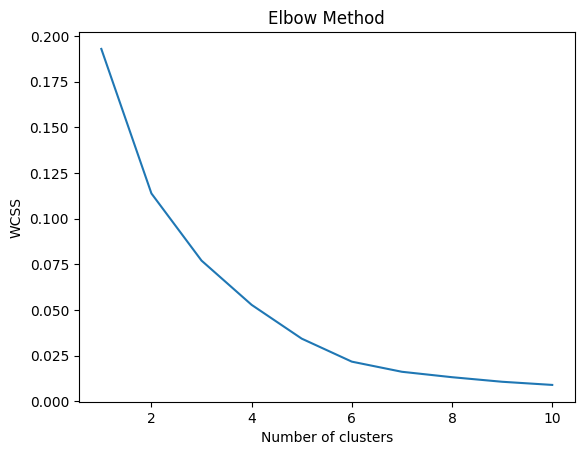

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# reduce dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)
print("Wcss loop done")

# Plot the elbow method to choose k
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


(1065024,)


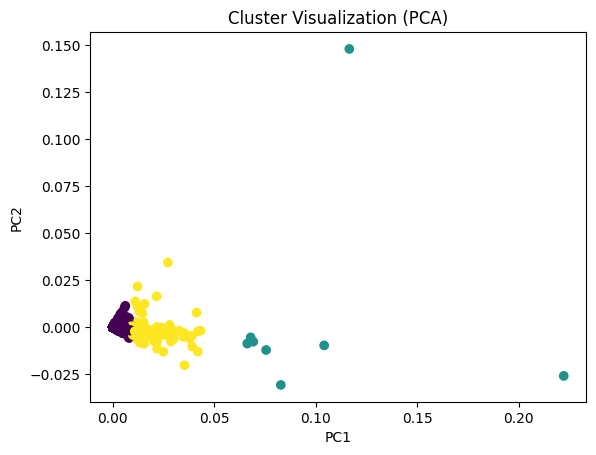

In [ ]:
# choosing k = 3
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(pca_data)

# Store data and cluster labels
data_df = pd.DataFrame(data)
data_df['cluster'] = kmeans.labels_
print(kmeans.labels_.shape)

# Extract data for plotting
pca_data1 = pca_data[:, 0]
pca_data2 = pca_data[:, 1]
clusters = data_df['cluster']

# Plot the clusters
plt.scatter(pca_data1, pca_data2, c=clusters)  # Color based on cluster labels
plt.title('Cluster Visualization (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, kmeans.labels_, test_size=0.9, random_state=42)
clf = LogisticRegression(C=1.0, penalty='elasticnet', solver='saga', l1_ratio=0.1)  # Elastic Net
clf.fit(X_train, y_train)

# Weights
coefficients = clf.coef_.flatten()
abs_coefficients = np.abs(coefficients)

In [ ]:
top_features_per_cluster = {}
for cluster in np.unique(kmeans.labels_):
  abs_coefficients = abs_coefficients.astype(np.int32)
  mask1 = kmeans.labels_ == cluster
  mask2 = abs_coefficients[kmeans.labels_] != 0  # Access coefficients for each data point based on cluster label

  combined_mask = mask2 & mask1

  # Get feature indices with non-zero coefficients for this cluster
  nonzero_indices = np.where(combined_mask)[0]

  # Sort features by absolute coefficient value (descending)
  top_features = np.argsort(abs_coefficients[nonzero_indices])[::-1][:10]

  # Store top features for the cluster
  top_features_per_cluster[cluster] = data.T.columns[nonzero_indices[top_features]]

'''
# Print the top features for each cluster
for cluster, features in top_features_per_cluster.items():
  print(f"Cluster {cluster}: {', '.join(features)}")
'''
